### Фильтр Собеля

На заре компьютерного зрения людям приходилось выполнять feature engeneering при обработке изображений в явном виде. То есть, было необходимо извлекать важную информацию из изображений. Довольно важной информацией на изображении являются границы: они могут быть использованы для большого количества задач (например, для поиска дорожной разметки на изображении). Как видно на изображении ниже, фильтры (в частности, фильтр Собеля) могут прекрасно справляться с поиском границ. С этим фильтром Вы ещё раз столкнётесь в ходе практической работы.

Пусть $A$ — это исходное изображение, а $G_{x}$ и $G _{y}$ — два изображения, на которых каждая точка содержит приближённые производные по $x$ и по $y$. Они вычисляются следующим образом:

$G_y=\begin{bmatrix}+1&+2&+1\\0&0&0\\-1&-2&-1\\\end{bmatrix}*A \\ G_x=\begin{bmatrix}-1&0&+1\\-2&0&+2\\-1&0&+1\\\end{bmatrix} *A $

где $*$ обозначает двумерную операцию свертки.

Координата $x$ здесь возрастает «направо», а $y$ — «вверх». В каждой точке изображения приближённое значение величины градиента можно вычислить путём использования полученных приближенных значений производных:

$G= \sqrt{{G_x^2}+{G_y^2}}$ (имеется в виду поэлементно).

Используя эту информацию, мы можем также вычислить направление градиента:

$\Theta = arctan(\frac{G_y}{G_x})$,

где, к примеру, угол $Θ$ равен нулю для вертикальной границы, у которой тёмная сторона слева.

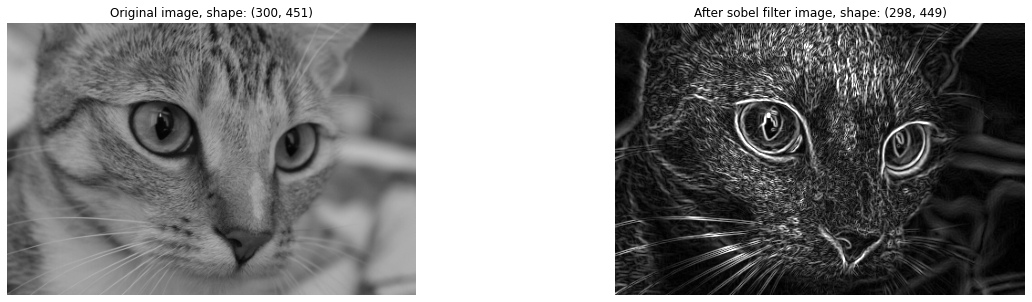

In [ ]:
img_cat = data.cat().mean(axis=2).astype("int32")


class Sobel(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter = nn.Conv2d(
            in_channels=1,
            out_channels=2,
            kernel_size=3,
            stride=1,
            padding=0,
            bias=False,
        )

        # fmt: off
        Gx = torch.tensor([[-1.0, 0.0, 1.0], 
                           [-2.0, 0.0, 2.0],
                           [-1.0, 0.0, 1.0]])
        
        Gy = torch.tensor([[1.0, 2.0, 1.0], 
                           [0.0, 0.0, 0.0],
                           [-1.0, -2.0, -1.0]])
        # fmt: on

        G = torch.cat([Gx.unsqueeze(0), Gy.unsqueeze(0)], 0)
        G = G.unsqueeze(1)
        self.filter.weight = nn.Parameter(G, requires_grad=False)

    def forward(self, img):
        x = self.filter(img)
        x = torch.mul(x, x)
        x = torch.sum(x, dim=1, keepdim=True)
        x = torch.sqrt(x)
        return x


sobel_filter = Sobel()
input = (
    torch.FloatTensor(img_cat).unsqueeze(0).unsqueeze(0)
)  # image to torch tensor shape: [1,1,300,451]
out = sobel_filter(input)
out = out.squeeze(0).squeeze(0)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].imshow(img_cat, cmap="gray", vmin=0, vmax=255)
# use .detach() to detached from the current graph(Requires grad = False)
axes[1].imshow(out.detach().numpy(), cmap="gray", vmin=0, vmax=255)
axes[0].set(title=f"Original image, shape: {img_cat.shape}")
axes[1].set(title=f"After sobel filter image, shape: {out.detach().numpy().shape}")
axes[0].axis("off")
axes[1].axis("off")
plt.show()

#### Детектор границ Canny

На самом деле, если мы будем применять упомянутый выше алгоритм без подготовки изображения и дополнительных операций, то не получим хорошее качество обнаружения границ. Поэтому существуют детекторы границ, дополняющие оператор Собеля, либо иные операторы (в алгоритме ниже оператор Собеля используется на шаге 2).

Алгоритм [Canny](https://en.wikipedia.org/wiki/Canny_edge_detector) включает 5 последовательных шагов: 
1. Сглаживание для удаления шума (фильтр Гаусса).
2. Поиск переходов (фильтр Собеля).
3. Фильтрация недостаточно резких переходов (отсечка переходов с градиентом меньше нижнего порогового значения).
4. Поиск сильных переходов (выбор пикселей с градиентом больше верхнего порогового значения). Переходы со значением градиента между нижним и верхним значением будут считаться слабыми.
5. Финализация границ. Истинными границами считаются сильные переходы и связанные с ними слабые.

Иллюстрацию работы алгоритма Canny можно увидеть по [ссылке](http://bigwww.epfl.ch/demo/ip/demos/edgeDetector/).

#### Детекторы углов

Другим примером созданных вручную экстракторов признаков являются всевозможные детекторы углов. Одним из самых известных среди них является детектор углов Харриса. Мы не будем на нем останавливаться, но Вы можете прочесть о нем самостоятельно в заметке [Corner Detector](https://en.wikipedia.org/wiki/Harris_Corner_Detector).

Как Вы увидите далее, сверточные нейронные сети по факту автоматизируют процесс извлечения подобных признаков, высвобождая время исследователей и инженеров.